# Pandas and duckdb

In [1]:
import duckdb
from pathlib import Path

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    discription = conn.sql("DESC;").df()
    films = conn.sql("FROM film;").df()

films.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,<NA>,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2021-03-06 15:52:00
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,<NA>,6,2.99,130,22.99,G,Deleted Scenes,2021-03-06 15:52:00


In [2]:
discription.head()

,database,schema,name,column_names,column_types,temporary
0,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
1,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
2,sakila,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False
3,sakila,main,city,"[city_id, city, country_id, last_update]","[BIGINT, VARCHAR, BIGINT, TIMESTAMP]",False
4,sakila,main,country,"[country_id, country, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False


In [3]:
## Read all data into dictionary of pandas dataframes

In [4]:
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in discription["name"]:
        dfs[name] = conn.sql(f"FROM {name};").df()

dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

In [5]:
dfs["film_actor"].head()

,actor_id,film_id,last_update
0,1,1,2021-03-06 15:52:45
1,1,23,2021-03-06 15:52:45
2,1,25,2021-03-06 15:52:45
3,1,106,2021-03-06 15:52:45
4,1,140,2021-03-06 15:52:45


## Register all dataframes in duckdb

In [6]:
film_names = ("film", "film_actor", "film_category", "actor", "category")

for film_name in film_names:
    duckdb.register(film_name, dfs[film_name])

duckdb.sql("DESC;").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",True
1,temp,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
2,temp,main,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",True
3,temp,main,film_actor,"[actor_id, film_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True
4,temp,main,film_category,"[film_id, category_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True


## Join film related dataframes using duckdb

In [7]:
films_joined =duckdb.sql("""
                SELECT
                     a.first_name || ' ' || a.last_name AS actor,
                     a.actor_id::INT AS actor_id,
                     f.title,
                     f.description,
                     f.release_year,
                     f.rental_duration,
                     f.rating,
                     c.name AS category,

                FROM film f
                     LEFT JOIN film_actor fa ON f.film_id = fa.film_id
                     LEFT JOIN actor a ON a.actor_id = fa.actor_id
                     LEFT JOIN film_category fc ON fc.film_id = f.film_id
                     LEFT JOIN category c ON fc.category_id = c.category_id;

             """).df()   
films_joined.head(10)

,actor,actor_id,title,description,release_year,rental_duration,rating,category
0,PENELOPE GUINESS,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,PG,Documentary
1,PENELOPE GUINESS,1,ANACONDA CONFESSIONS,A Lacklusture Display of a Dentist And a Denti...,2006,3,R,Animation
2,PENELOPE GUINESS,1,ANGELS LIFE,A Thoughtful Display of a Woman And a Astronau...,2006,3,G,New
3,PENELOPE GUINESS,1,BULWORTH COMMANDMENTS,A Amazing Display of a Mad Cow And a Pioneer w...,2006,4,G,Games
4,PENELOPE GUINESS,1,CHEAPER CLYDE,A Emotional Character Study of a Pioneer And a...,2006,6,G,Sci-Fi
5,PENELOPE GUINESS,1,COLOR PHILADELPHIA,A Thoughtful Panorama of a Car And a Crocodile...,2006,6,G,Classics
6,PENELOPE GUINESS,1,ELEPHANT TROJAN,A Beautiful Panorama of a Lumberjack And a For...,2006,4,PG-13,Horror
7,PENELOPE GUINESS,1,GLEAMING JAWBREAKER,A Amazing Display of a Composer And a Forensic...,2006,5,NC-17,Sports
8,PENELOPE GUINESS,1,HUMAN GRAFFITI,A Beautiful Reflection of a Womanizer And a Su...,2006,3,NC-17,Games
9,PENELOPE GUINESS,1,KING EVOLUTION,A Action-Packed Tale of a Boy And a Lumberjack...,2006,3,NC-17,Family


In [8]:
films_joined.columns

Index(['actor', 'actor_id', 'title', 'description', 'release_year',
       'rental_duration', 'rating', 'category'],
      dtype='object')

## now do some more EDA

In [9]:
films_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   actor            5462 non-null   object
 1   actor_id         5462 non-null   Int32 
 2   title            5465 non-null   object
 3   description      5465 non-null   object
 4   release_year     5465 non-null   object
 5   rental_duration  5465 non-null   int64 
 6   rating           5465 non-null   object
 7   category         5465 non-null   object
dtypes: Int32(1), int64(1), object(6)
memory usage: 325.7+ KB


In [10]:
films_joined["rating"].value_counts()

rating
PG-13    1184
PG       1143
NC-17    1128
R        1033
G         977
Name: count, dtype: int64

In [11]:
films_joined["rental_duration"].value_counts()

rental_duration
6    1201
4    1113
3    1087
5    1057
7    1007
Name: count, dtype: int64

In [12]:
films_joined.describe()["rental_duration"]

count    5465.000000
mean        4.986825
std         1.398667
min         3.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         7.000000
Name: rental_duration, dtype: float64

## which top 10 actors have played in most films?

In [13]:
actor_films = duckdb.sql("""
    SELECT
           actor,
           COUNT(*) AS number_films
    FROM films_joined
    GROUP BY actor
    ORDER BY number_films DESC;
""").df()

actor_films.head(10)

,actor,number_films
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,VAL BOLGER,35
8,VIVIEN BASINGER,35
9,ANGELA WITHERSPOON,35


## visualize this

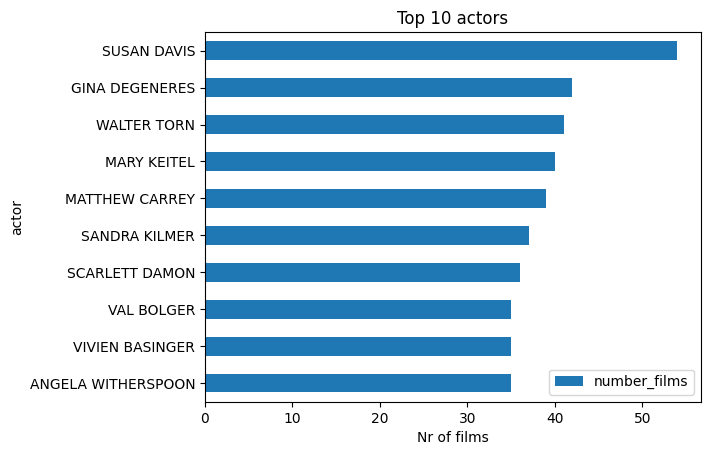

In [14]:
ax = actor_films.head (10).plot (
    kind = "barh",
    x = "actor",
    y = "number_films",
    title = "Top 10 actors",
    xlabel= "Nr of films",
)
ax.invert_yaxis()